In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('./drive/My Drive/ERA5_Dataset')

Mounted at /content/drive


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingClassifier
from datetime import datetime

import pickle
import metrics
import datashift

# KDE Examples

## My KDE implementation

In [6]:
# dataset
x = [1.33, 0.3, 0.97, 1.1, 0.1, 1.4, 0.4]
# bandwidth
h = 0.3

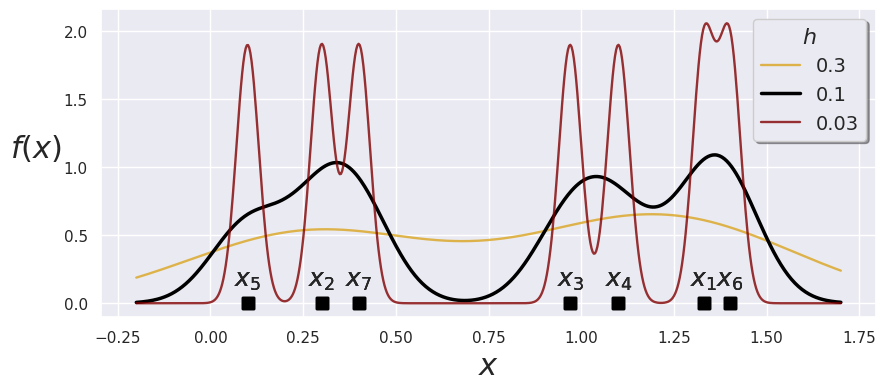

In [7]:
# the Kernel function
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

# dummy dataset
dataset = np.array([1.33, 0.3, 0.97, 1.1, 0.1, 1.4, 0.4])

# x-value range for plotting KDEs
x_range = np.linspace(dataset.min()-0.3, dataset.max()+0.3, num=600)

# bandwith values for experimentation
H = [0.3, 0.1, 0.03]
n_samples = dataset.size

# line properties for different bandwith values
color_list = ['goldenrod', 'black', 'maroon']
alpha_list = [0.8, 1, 0.8]
width_list = [1.7,2.5,1.7]

plt.figure(figsize=(10,4))
# iterate over bandwith values
for h, color, alpha, width in zip(H, color_list, alpha_list, width_list):
    total_sum = 0
    # iterate over datapoints
    for i, xi in enumerate(dataset):
        total_sum += K((x_range - xi) / h)
        plt.annotate(r'$x_{}$'.format(i+1),
                     xy=[xi, 0.13],
                     horizontalalignment='center',
                     fontsize=18,
                    )
    y_range = total_sum/(h*n_samples)
    plt.plot(x_range, y_range,
             color=color, alpha=alpha, linewidth=width,
             label=f'{h}')

    plt.plot(dataset, np.zeros_like(dataset) , 's',
             markersize=8, color='black')

plt.xlabel('$x$', fontsize=22)
plt.ylabel('$f(x)$', fontsize=22, rotation='horizontal', labelpad=20)
plt.legend(fontsize=14, shadow=True, title='$h$', title_fontsize=16)
plt.show()

## Seaborn implementation

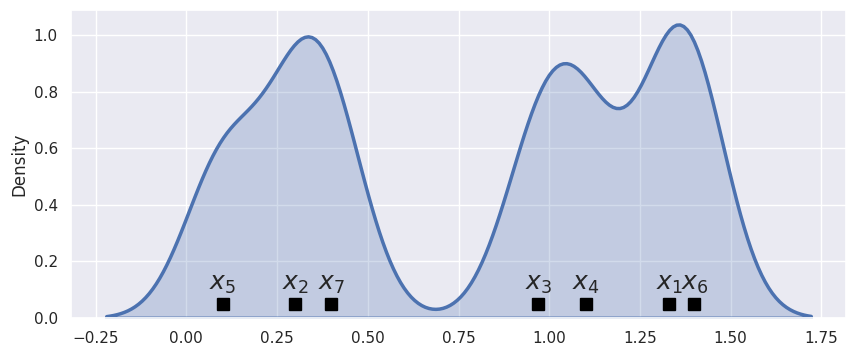

In [8]:
sns.set()

fig, ax = plt.subplots(figsize=(10,4))

sns.kdeplot(ax=ax, data=dataset,
            bw_adjust=0.3,
            linewidth=2.5, fill=True)

# plot datapoints
ax.plot(dataset, np.zeros_like(dataset) + 0.05, 's',
        markersize=8, color='black')
for i, xi in enumerate(dataset):
    plt.annotate(r'$x_{}$'.format(i+1),
                 xy=[xi, 0.1],
                 horizontalalignment='center',
                 fontsize=18,
                )
plt.show()

## Sklearn implementation

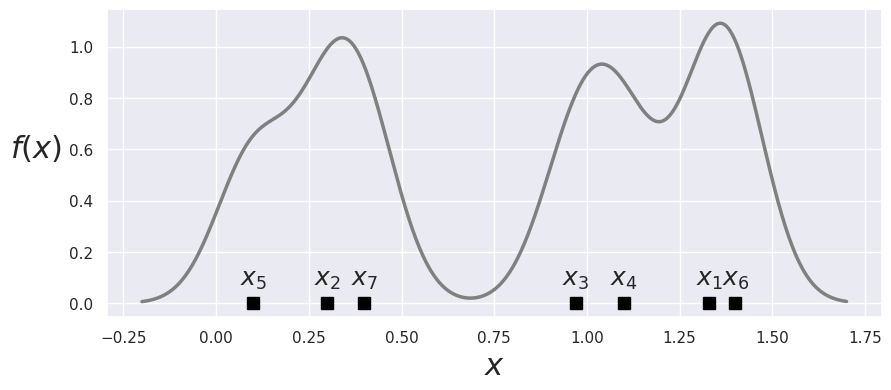

In [9]:
from sklearn.neighbors import KernelDensity

dataset = np.array([1.33, 0.3, 0.97, 1.1, 0.1, 1.4, 0.4])

# KernelDensity requires 2D array
dataset = dataset[:, np.newaxis]

# fit KDE to the dataset
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(dataset)

# x-value range for plotting KDE
x_range = np.linspace(dataset.min()-0.3, dataset.max()+0.3, num=600)

# compute the log-likelihood of each sample
log_density = kde.score_samples(x_range[:, np.newaxis])

plt.figure(figsize=(10,4))
# put labels over datapoints
for i, xi in enumerate(dataset):
    plt.annotate(r'$x_{}$'.format(i+1),
                 xy=[xi, 0.07],
                 horizontalalignment='center',
                 fontsize=18)

# draw KDE curve
plt.plot(x_range, np.exp(log_density),
         color='gray', linewidth=2.5)

# draw boxes representing datapoints
plt.plot(dataset, np.zeros_like(dataset) , 's',
         markersize=8, color='black')

plt.xlabel('$x$', fontsize=22)
plt.ylabel('$f(x)$', fontsize=22, rotation='horizontal', labelpad=24)
plt.show()

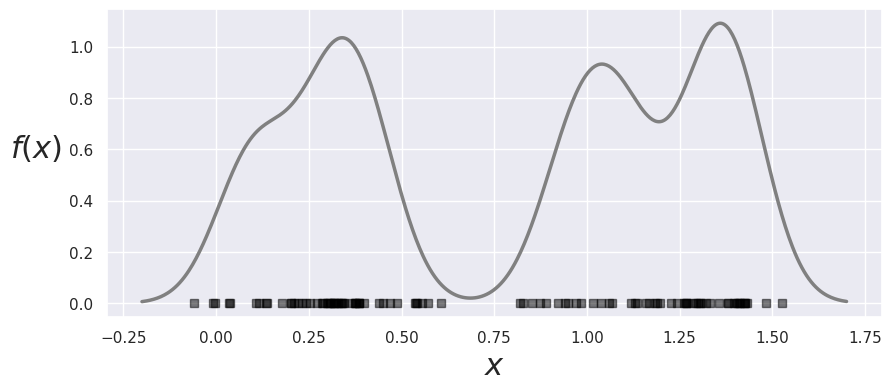

In [10]:
# Generate random samples from the model
synthetic_data = kde.sample(100)

plt.figure(figsize=(10,4))

# draw KDE curve
plt.plot(x_range, np.exp(log_density),
         color='gray', linewidth=2.5)

# draw boxes representing datapoints
plt.plot(synthetic_data, np.zeros_like(synthetic_data) , 's',
         markersize=6, color='black', alpha=0.5)

plt.xlabel('$x$', fontsize=22)
plt.ylabel('$f(x)$', fontsize=22, rotation='horizontal', labelpad=24)
plt.show()

# Evaluate variable distribution over 4 geogrphical zones

## KDE for Wind Gust

In [13]:
df = pd.read_csv('./DATASET_COMPLETED/4_zones_avg_std_10D.csv')

dates = df['DATE'].values
ydays = []
for date_str in dates:
    date = datetime.strptime(date_str, '%Y-%m-%d')
    day_of_year = date.timetuple().tm_yday
    ydays.append(day_of_year)
df['yday'] = ydays
df = df.set_index('DATE')

df_target = df['S.IndAll']
df_allvars = df.drop(['S.IndAll'], axis=1)

df_allvars

,S.IndGen,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,...,Air_Density_Std_Z4-2,Air_Density_Std_Z4-3,Air_Density_Std_Z4-4,Air_Density_Std_Z4-5,Air_Density_Std_Z4-6,Air_Density_Std_Z4-7,Air_Density_Std_Z4-8,Air_Density_Std_Z4-9,Air_Density_Std_Z4-10,yday
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-12,0.0,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,101050.549540,101073.565413,101016.098485,...,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,0.010108,0.009511,0.009395,12
1980-01-13,0.0,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,101050.549540,101073.565413,...,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,0.010108,0.009511,13
1980-01-14,0.0,101085.674846,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,101050.549540,...,0.013063,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,0.010108,14
1980-01-15,0.0,101118.532122,101085.674846,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,...,0.013794,0.013063,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,15
1980-01-16,0.0,101143.786218,101118.532122,101085.674846,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,...,0.013889,0.013794,0.013063,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-23,1.0,101145.753803,101027.591097,101024.981003,101044.786057,101137.015271,101042.842803,100814.887469,100848.926329,100959.178310,...,0.012363,0.013324,0.014253,0.013234,0.012444,0.013086,0.013969,0.012934,0.011182,82
2022-03-24,0.0,101129.173131,101145.753803,101027.591097,101024.981003,101044.786057,101137.015271,101042.842803,100814.887469,100848.926329,...,0.012701,0.012363,0.013324,0.014253,0.013234,0.012444,0.013086,0.013969,0.012934,83
2022-03-25,0.0,100988.384475,101129.173131,101145.753803,101027.591097,101024.981003,101044.786057,101137.015271,101042.842803,100814.887469,...,0.012427,0.012701,0.012363,0.013324,0.014253,0.013234,0.012444,0.013086,0.013969,84


In [18]:
df_allvars.columns[1::88]

Index(['P_Mean_Z1-0', 'Vor_850hPa_Mean_Z1-0', 'Vor_550hPa_Mean_Z1-0',
       'Vor_250hPa_Mean_Z1-0', 'Wind_Gust_Mean_Z1-0', 'Wind_U_10m_Mean_Z1-0',
       'Wind_U_1000hPa_Mean_Z1-0', 'Wind_U_850hPa_Mean_Z1-0',
       'Wind_U_300hPa_Mean_Z1-0', 'Wind_V_10m_Mean_Z1-0',
       'Wind_V_1000hPa_Mean_Z1-0', 'Wind_V_850hPa_Mean_Z1-0',
       'Wind_V_300hPa_Mean_Z1-0', 'T_1000hPa_Mean_Z1-0', 'T_550hPa_Mean_Z1-0',
       'T_300hPa_Mean_Z1-0', 'T_200hPa_Mean_Z1-0', 'Prec_Mean_Z1-0',
       'Air_Density_Mean_Z1-0', 'yday'],
      dtype='object')

In [28]:
df_wind = df_allvars[['Wind_Gust_Mean_Z1-0', 'Wind_Gust_Mean_Z2-0', 'Wind_Gust_Mean_Z3-0', 'Wind_Gust_Mean_Z4-0']]
wind_z1 = df_wind['Wind_Gust_Mean_Z1-0'].values
wind_z2 = df_wind['Wind_Gust_Mean_Z2-0'].values
wind_z3 = df_wind['Wind_Gust_Mean_Z3-0'].values
wind_z4 = df_wind['Wind_Gust_Mean_Z4-0'].values
z1_flag_arr = np.full(wind_z1.shape, 1)
z2_flag_arr = np.full(wind_z2.shape, 2)
z3_flag_arr = np.full(wind_z3.shape, 3)
z4_flag_arr = np.full(wind_z4.shape, 4)

wind_arr = np.concatenate((wind_z1, wind_z2, wind_z3, wind_z4))
flag_arr = np.concatenate((z1_flag_arr, z2_flag_arr, z3_flag_arr, z4_flag_arr))
# Create a DataFrame using the arrays
data = {'Wind': wind_arr, 'Zone': flag_arr}
df_kde = pd.DataFrame(data)

df_kde

,Wind,Zone
0,7.406750,1
1,7.143797,1
2,6.400135,1
3,6.812498,1
4,6.488345,1
...,...,...
61659,11.283790,4
61660,10.398246,4
61661,11.244720,4
61662,11.877448,4


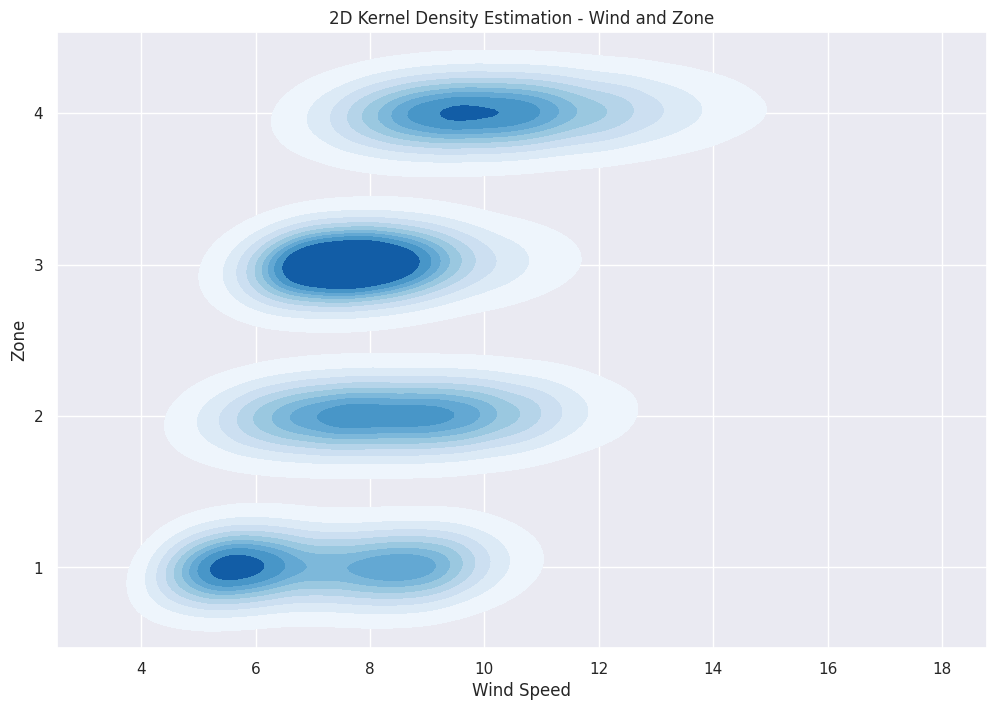

In [31]:
# Create a 2D KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(x='Wind', y='Zone', data=df_kde, cmap="Blues", fill=True)

# Set custom y-axis tick values
custom_y_ticks = [1, 2, 3, 4]
plt.yticks(custom_y_ticks)

plt.title('2D Kernel Density Estimation - Wind and Zone')
plt.xlabel('Wind Speed')
plt.ylabel('Zone')

plt.show()

## KDE for pressure

In [34]:
df_wind = df_allvars[['P_Mean_Z1-0', 'P_Mean_Z2-0', 'P_Mean_Z3-0', 'P_Mean_Z4-0']]
wind_z1 = df_wind['P_Mean_Z1-0'].values
wind_z2 = df_wind['P_Mean_Z2-0'].values
wind_z3 = df_wind['P_Mean_Z3-0'].values
wind_z4 = df_wind['P_Mean_Z4-0'].values
z1_flag_arr = np.full(wind_z1.shape, 1)
z2_flag_arr = np.full(wind_z2.shape, 2)
z3_flag_arr = np.full(wind_z3.shape, 3)
z4_flag_arr = np.full(wind_z4.shape, 4)

wind_arr = np.concatenate((wind_z1, wind_z2, wind_z3, wind_z4))
flag_arr = np.concatenate((z1_flag_arr, z2_flag_arr, z3_flag_arr, z4_flag_arr))
# Create a DataFrame using the arrays
data = {'Pressure': wind_arr, 'Zone': flag_arr}
df_kde = pd.DataFrame(data)

df_kde

,Pressure,Zone
0,100891.502492,1
1,100971.284922,1
2,101085.674846,1
3,101118.532122,1
4,101143.786218,1
...,...,...
61659,101468.014268,4
61660,101246.375619,4
61661,101181.953166,4
61662,101235.977340,4


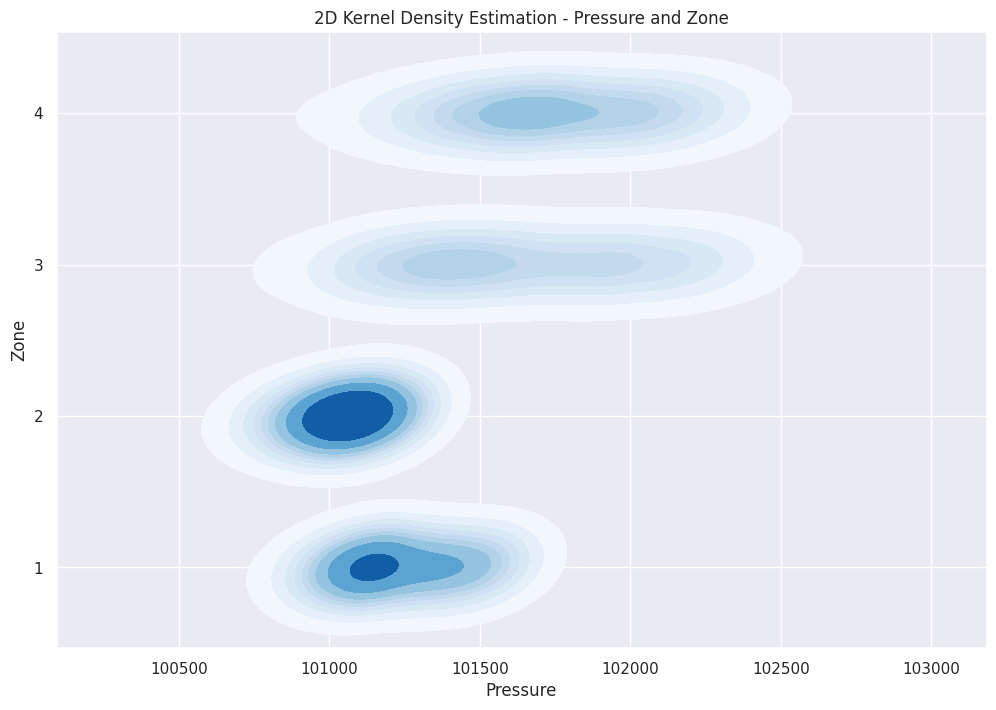

In [35]:
# Create a 2D KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(x='Pressure', y='Zone', data=df_kde, cmap="Blues", fill=True)

# Set custom y-axis tick values
custom_y_ticks = [1, 2, 3, 4]
plt.yticks(custom_y_ticks)

plt.title('2D Kernel Density Estimation - Pressure and Zone')
plt.xlabel('Pressure')
plt.ylabel('Zone')

plt.show()

## KDE for Sea Surface Temperature

In [39]:
df_wind = df_allvars[['T_1000hPa_Mean_Z1-0', 'T_1000hPa_Mean_Z2-0', 'T_1000hPa_Mean_Z3-0', 'T_1000hPa_Mean_Z4-0']]
sst_z1 = df_wind['T_1000hPa_Mean_Z1-0'].values - 273.15
sst_z2 = df_wind['T_1000hPa_Mean_Z2-0'].values - 273.15
sst_z3 = df_wind['T_1000hPa_Mean_Z3-0'].values - 273.15
sst_z4 = df_wind['T_1000hPa_Mean_Z4-0'].values - 273.15
z1_flag_arr = np.full(wind_z1.shape, 1)
z2_flag_arr = np.full(wind_z2.shape, 2)
z3_flag_arr = np.full(wind_z3.shape, 3)
z4_flag_arr = np.full(wind_z4.shape, 4)

sst_arr = np.concatenate((sst_z1, sst_z2, sst_z3, sst_z4))
flag_arr = np.concatenate((z1_flag_arr, z2_flag_arr, z3_flag_arr, z4_flag_arr))
# Create a DataFrame using the arrays
data = {'SST': sst_arr, 'Zone': flag_arr}
df_kde = pd.DataFrame(data)

df_kde

,SST,Zone
0,26.024026,1
1,26.007578,1
2,26.080960,1
3,26.027273,1
4,25.839116,1
...,...,...
61659,23.952330,4
61660,23.858817,4
61661,23.734725,4
61662,23.945445,4


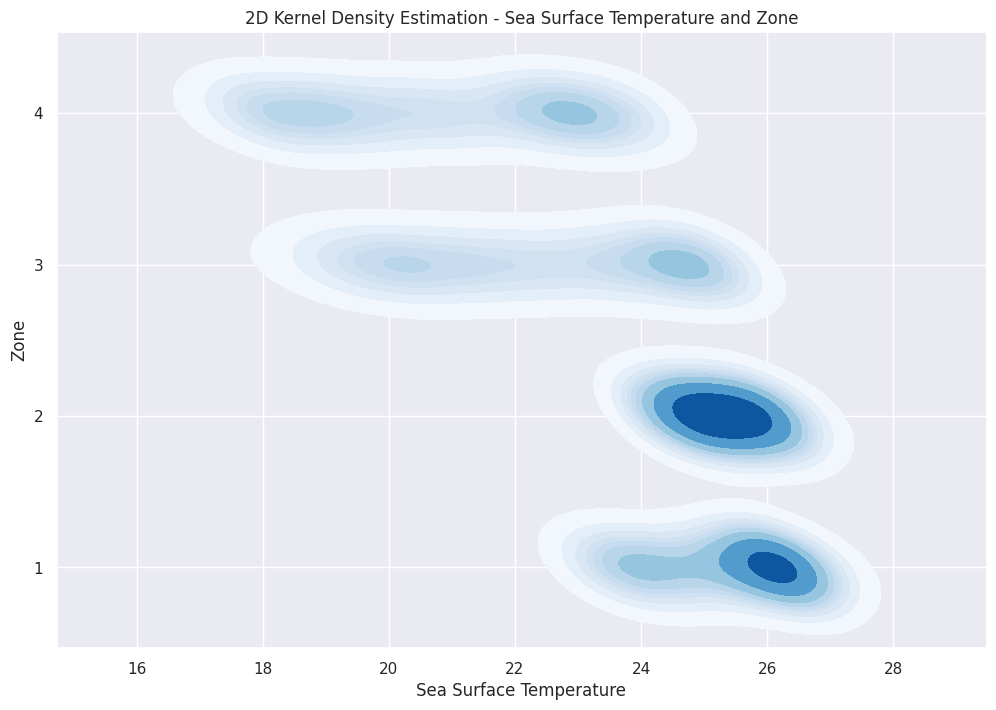

In [40]:
# Create a 2D KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(x='SST', y='Zone', data=df_kde, cmap="Blues", fill=True)

# Set custom y-axis tick values
custom_y_ticks = [1, 2, 3, 4]
plt.yticks(custom_y_ticks)

plt.title('2D Kernel Density Estimation - Sea Surface Temperature and Zone')
plt.xlabel('Sea Surface Temperature')
plt.ylabel('Zone')

plt.show()

# Evaluate variables distribution over weeks of the year

In [41]:
df = pd.read_csv('./DATASET_COMPLETED/4_zones_avg_std_10D.csv')

dates = df['DATE'].values
ydays = []
for date_str in dates:
    date = datetime.strptime(date_str, '%Y-%m-%d')
    day_of_year = date.timetuple().tm_yday
    ydays.append(day_of_year)
df['yday'] = ydays
df = df.set_index('DATE')

df_target = df['S.IndAll']
df_allvars = df.drop(['S.IndAll'], axis=1)

df_allvars

,S.IndGen,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,...,Air_Density_Std_Z4-2,Air_Density_Std_Z4-3,Air_Density_Std_Z4-4,Air_Density_Std_Z4-5,Air_Density_Std_Z4-6,Air_Density_Std_Z4-7,Air_Density_Std_Z4-8,Air_Density_Std_Z4-9,Air_Density_Std_Z4-10,yday
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-12,0.0,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,101050.549540,101073.565413,101016.098485,...,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,0.010108,0.009511,0.009395,12
1980-01-13,0.0,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,101050.549540,101073.565413,...,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,0.010108,0.009511,13
1980-01-14,0.0,101085.674846,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,101050.549540,...,0.013063,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,0.010108,14
1980-01-15,0.0,101118.532122,101085.674846,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,101000.534026,...,0.013794,0.013063,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,0.010385,15
1980-01-16,0.0,101143.786218,101118.532122,101085.674846,100971.284922,100891.502492,100953.820661,101027.968978,101121.703110,101054.771816,...,0.013889,0.013794,0.013063,0.010556,0.009881,0.008575,0.009597,0.009420,0.010146,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-23,1.0,101145.753803,101027.591097,101024.981003,101044.786057,101137.015271,101042.842803,100814.887469,100848.926329,100959.178310,...,0.012363,0.013324,0.014253,0.013234,0.012444,0.013086,0.013969,0.012934,0.011182,82
2022-03-24,0.0,101129.173131,101145.753803,101027.591097,101024.981003,101044.786057,101137.015271,101042.842803,100814.887469,100848.926329,...,0.012701,0.012363,0.013324,0.014253,0.013234,0.012444,0.013086,0.013969,0.012934,83
2022-03-25,0.0,100988.384475,101129.173131,101145.753803,101027.591097,101024.981003,101044.786057,101137.015271,101042.842803,100814.887469,...,0.012427,0.012701,0.012363,0.013324,0.014253,0.013234,0.012444,0.013086,0.013969,84


In [42]:
df_allvars.columns[1::88]

Index(['P_Mean_Z1-0', 'Vor_850hPa_Mean_Z1-0', 'Vor_550hPa_Mean_Z1-0',
       'Vor_250hPa_Mean_Z1-0', 'Wind_Gust_Mean_Z1-0', 'Wind_U_10m_Mean_Z1-0',
       'Wind_U_1000hPa_Mean_Z1-0', 'Wind_U_850hPa_Mean_Z1-0',
       'Wind_U_300hPa_Mean_Z1-0', 'Wind_V_10m_Mean_Z1-0',
       'Wind_V_1000hPa_Mean_Z1-0', 'Wind_V_850hPa_Mean_Z1-0',
       'Wind_V_300hPa_Mean_Z1-0', 'T_1000hPa_Mean_Z1-0', 'T_550hPa_Mean_Z1-0',
       'T_300hPa_Mean_Z1-0', 'T_200hPa_Mean_Z1-0', 'Prec_Mean_Z1-0',
       'Air_Density_Mean_Z1-0', 'yday'],
      dtype='object')

In [54]:
dates = df_allvars.index

def get_week_number(date_str):
    # Convert the date string to a datetime object
    date_object = datetime.strptime(date_str, '%Y-%m-%d')
    # Use strftime to get the ISO week number
    week_number = date_object.strftime('%V')
    return int(week_number)

week_number_list = []
for elem in dates:
  week_number_list.append(get_week_number(elem))

week_number_arr = np.array(week_number_list)
print(week_number_arr.shape)
print(week_number_arr)

(15416,)
[ 2  2  3 ... 12 12 12]


In [55]:
df_wind = df_allvars[['Wind_Gust_Mean_Z1-0', 'Wind_Gust_Mean_Z2-0', 'Wind_Gust_Mean_Z3-0', 'Wind_Gust_Mean_Z4-0']]
df_wind['WEEK'] = week_number_arr
df_wind

<ipython-input-55-4eb519891faa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wind['WEEK'] = week_number_arr


,Wind_Gust_Mean_Z1-0,Wind_Gust_Mean_Z2-0,Wind_Gust_Mean_Z3-0,Wind_Gust_Mean_Z4-0,WEEK
DATE,,,,,
1980-01-12,7.406750,8.095662,8.816201,10.533493,2
1980-01-13,7.143797,7.069916,7.469558,10.750207,2
1980-01-14,6.400135,7.401104,6.818709,11.285153,3
1980-01-15,6.812498,7.517227,7.757419,10.628481,3
1980-01-16,6.488345,7.387735,9.160325,9.530735,3
...,...,...,...,...,...
2022-03-23,5.582984,8.438066,7.444604,11.283790,12
2022-03-24,5.559951,9.024209,6.678266,10.398246,12
2022-03-25,4.806186,9.647772,5.955352,11.244720,12


In [56]:
wind_z1 = df_wind['Wind_Gust_Mean_Z1-0'].values
wind_z2 = df_wind['Wind_Gust_Mean_Z2-0'].values
wind_z3 = df_wind['Wind_Gust_Mean_Z3-0'].values
wind_z4 = df_wind['Wind_Gust_Mean_Z4-0'].values
z1_flag_arr = df_wind['WEEK'].values
z2_flag_arr = df_wind['WEEK'].values
z3_flag_arr = df_wind['WEEK'].values
z4_flag_arr = df_wind['WEEK'].values

wind_arr = np.concatenate((wind_z1, wind_z2, wind_z3, wind_z4))
flag_arr = np.concatenate((z1_flag_arr, z2_flag_arr, z3_flag_arr, z4_flag_arr))
# Create a DataFrame using the arrays
data = {'Wind': wind_arr, 'Week': flag_arr}
df_kde = pd.DataFrame(data)

df_kde

,Wind,Week
0,7.406750,2
1,7.143797,2
2,6.400135,3
3,6.812498,3
4,6.488345,3
...,...,...
61659,11.283790,12
61660,10.398246,12
61661,11.244720,12
61662,11.877448,12


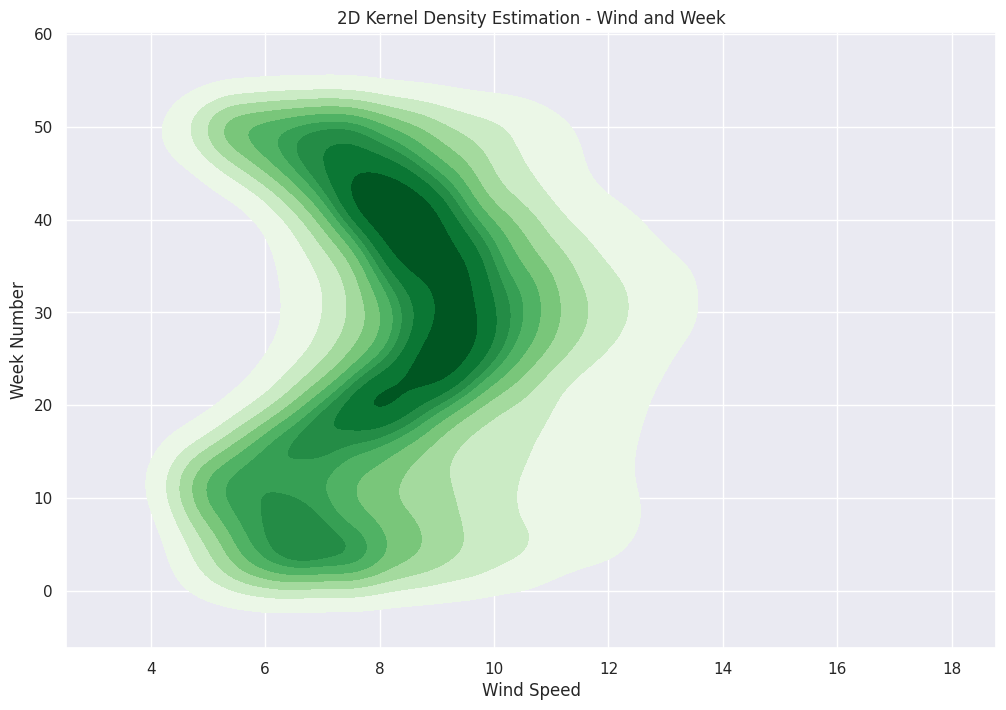

In [58]:
# Create a 2D KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(x='Wind', y='Week', data=df_kde, cmap="Greens", fill=True)

# Set custom y-axis tick values
#custom_y_ticks = [1, 2, 3, 4]
#plt.yticks(custom_y_ticks)

plt.title('2D Kernel Density Estimation - Wind and Week')
plt.xlabel('Wind Speed')
plt.ylabel('Week Number')

plt.show()

## Pressure

In [61]:
df_press = df_allvars[['P_Mean_Z1-0', 'P_Mean_Z2-0', 'P_Mean_Z3-0', 'P_Mean_Z4-0']]
df_press['WEEK'] = week_number_arr
df_press

<ipython-input-61-c65697e73587>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_press['WEEK'] = week_number_arr


,P_Mean_Z1-0,P_Mean_Z2-0,P_Mean_Z3-0,P_Mean_Z4-0,WEEK
DATE,,,,,
1980-01-12,100891.502492,100883.047200,100776.744133,101250.443092,2
1980-01-13,100971.284922,100889.039843,100906.681575,101371.003621,2
1980-01-14,101085.674846,100936.662205,101160.314299,101444.149843,3
1980-01-15,101118.532122,101027.915134,101273.302950,101519.672906,3
1980-01-16,101143.786218,101018.826376,101248.678643,101400.591474,3
...,...,...,...,...,...
2022-03-23,101145.753803,100787.924470,101579.791174,101468.014268,12
2022-03-24,101129.173131,100694.316002,101363.201357,101246.375619,12
2022-03-25,100988.384475,100677.299730,101048.754691,101181.953166,12


In [63]:
press_z1 = df_press['P_Mean_Z1-0'].values
press_z2 = df_press['P_Mean_Z2-0'].values
press_z3 = df_press['P_Mean_Z3-0'].values
press_z4 = df_press['P_Mean_Z4-0'].values
z1_flag_arr = df_press['WEEK'].values
z2_flag_arr = df_press['WEEK'].values
z3_flag_arr = df_press['WEEK'].values
z4_flag_arr = df_press['WEEK'].values

press_arr = np.concatenate((press_z1, press_z2, press_z3, press_z4))
flag_arr = np.concatenate((z1_flag_arr, z2_flag_arr, z3_flag_arr, z4_flag_arr))
# Create a DataFrame using the arrays
data = {'Pressure': press_arr, 'Week': flag_arr}
df_kde = pd.DataFrame(data)

df_kde

,Pressure,Week
0,100891.502492,2
1,100971.284922,2
2,101085.674846,3
3,101118.532122,3
4,101143.786218,3
...,...,...
61659,101468.014268,12
61660,101246.375619,12
61661,101181.953166,12
61662,101235.977340,12


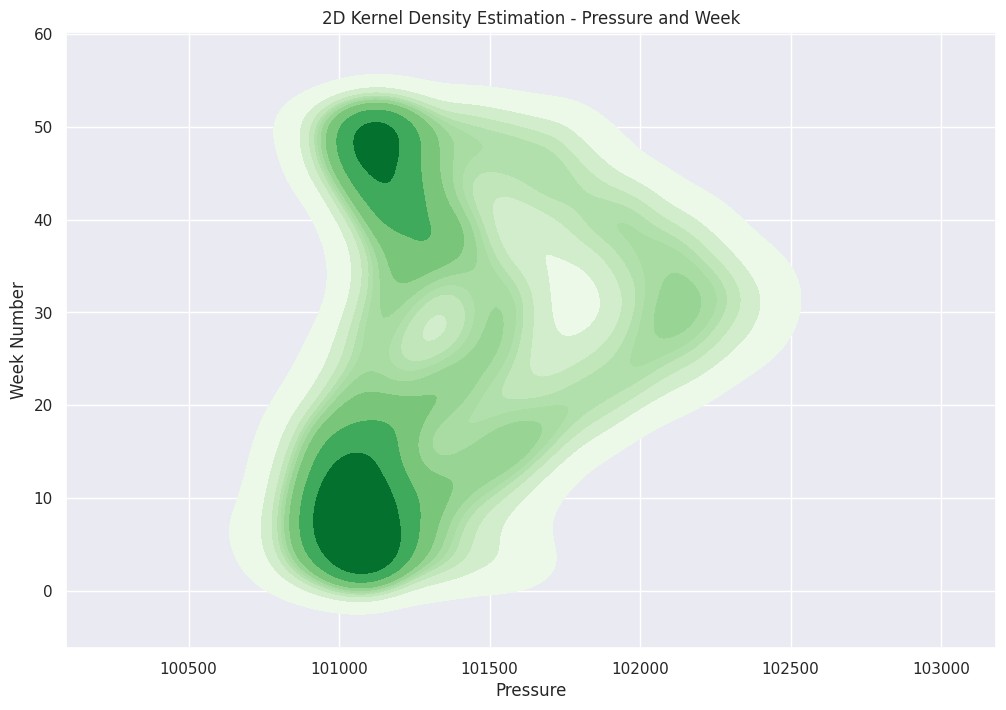

In [64]:
# Create a 2D KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(x='Pressure', y='Week', data=df_kde, cmap="Greens", fill=True)

# Set custom y-axis tick values
#custom_y_ticks = [1, 2, 3, 4]
#plt.yticks(custom_y_ticks)

plt.title('2D Kernel Density Estimation - Pressure and Week')
plt.xlabel('Pressure')
plt.ylabel('Week Number')

plt.show()

## Sea Surface Temperature

In [66]:
df_temp = df_allvars[['T_1000hPa_Mean_Z1-0',
                       'T_1000hPa_Mean_Z2-0',
                       'T_1000hPa_Mean_Z3-0',
                       'T_1000hPa_Mean_Z4-0']]
df_temp['WEEK'] = week_number_arr
df_temp

<ipython-input-66-54f53ebd4d6f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['WEEK'] = week_number_arr


,T_1000hPa_Mean_Z1-0,T_1000hPa_Mean_Z2-0,T_1000hPa_Mean_Z3-0,T_1000hPa_Mean_Z4-0,WEEK
DATE,,,,,
1980-01-12,299.174026,298.584459,297.563431,296.279075,2
1980-01-13,299.157578,298.572206,297.725298,295.997500,2
1980-01-14,299.230960,298.306253,297.381193,296.023391,3
1980-01-15,299.177273,298.252639,297.079561,296.143359,3
1980-01-16,298.989116,298.448346,297.027825,296.749218,3
...,...,...,...,...,...
2022-03-23,299.636797,299.846455,297.158660,297.102330,12
2022-03-24,300.089355,299.926067,297.728440,297.008817,12
2022-03-25,300.504476,300.003114,298.589725,296.884725,12


In [67]:
temp_z1 = df_temp['T_1000hPa_Mean_Z1-0'].values - 273.15
temp_z2 = df_temp['T_1000hPa_Mean_Z2-0'].values - 273.15
temp_z3 = df_temp['T_1000hPa_Mean_Z3-0'].values - 273.15
temp_z4 = df_temp['T_1000hPa_Mean_Z4-0'].values - 273.15
z1_flag_arr = df_press['WEEK'].values
z2_flag_arr = df_press['WEEK'].values
z3_flag_arr = df_press['WEEK'].values
z4_flag_arr = df_press['WEEK'].values

press_arr = np.concatenate((temp_z1, temp_z2, temp_z3, temp_z4))
flag_arr = np.concatenate((z1_flag_arr, z2_flag_arr, z3_flag_arr, z4_flag_arr))
# Create a DataFrame using the arrays
data = {'SST': press_arr, 'Week': flag_arr}
df_kde = pd.DataFrame(data)

df_kde

,SST,Week
0,26.024026,2
1,26.007578,2
2,26.080960,3
3,26.027273,3
4,25.839116,3
...,...,...
61659,23.952330,12
61660,23.858817,12
61661,23.734725,12
61662,23.945445,12


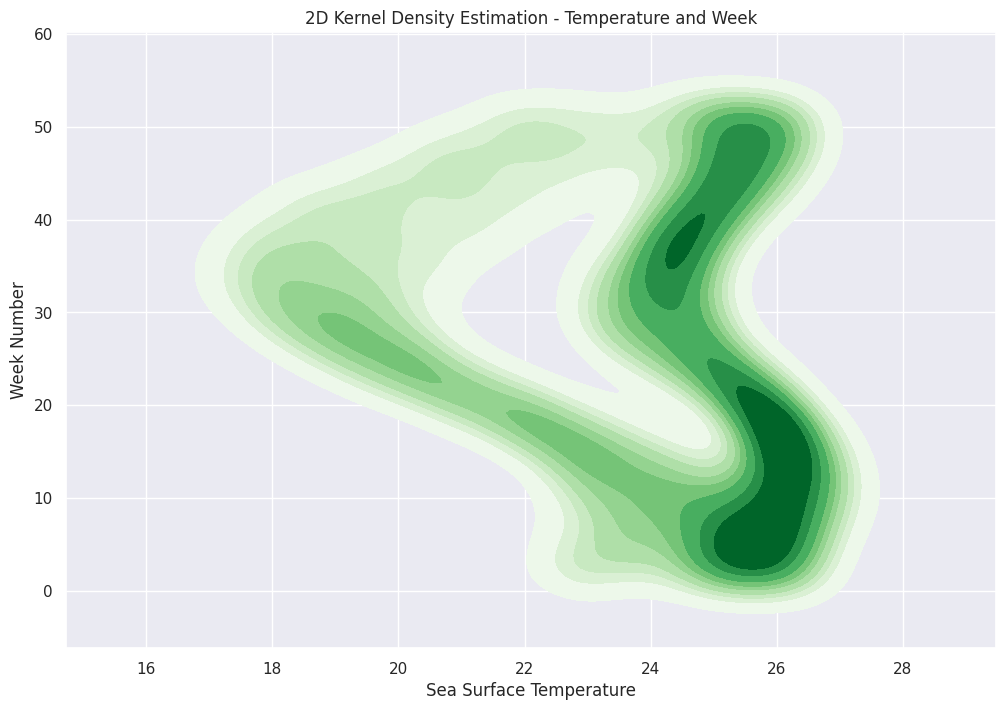

In [68]:
# Create a 2D KDE plot
plt.figure(figsize=(12, 8))
sns.kdeplot(x='SST', y='Week', data=df_kde, cmap="Greens", fill=True)

plt.title('2D Kernel Density Estimation - Temperature and Week')
plt.xlabel('Sea Surface Temperature')
plt.ylabel('Week Number')

plt.show()